In [7]:
import os

# Generating the NDSCs

Starting from a POSCAR file in a `root` directory, (conventional or primitive or whatever), we can use the `generate_files` utility to generate the NDSCs. The utility does the following:
1. If your POSCAR is not a standard primitive cell, it will dump a file `POSCAR_symm` file which is in a standard setting. All supercells are based on this standard setting.
2. It will generate a file `quesadilla.toml` with information about the primitive cells, grid and IBZ, and the supercells.
3. In the `root`, it will generate folders sc-1, sc-2, sc-3, ... sc-N, one for each nondiagonal supercell. Those folders will have:
    * a file make_disp.conf to be used with phonopy to generate the displacements
    * a file get_yaml.conf to be used with phonopy to generate a phonopy.yaml file with the force constants after you run the DFT calculations and generate the FORCE_SETS
    * a file POSCAR which is the standard primitive cell
    * a file quesadilla_ndsc.vasp which is the nondiagonal supercell. This should be the exact same structure that phonopy will generate (`SPOSCAR` file).
    * a K-Points file based on the k-spacing you selected. This is just a regular k-grid with the correct density for each nondiagonal supercell. Ideally we should move to using generalized regular grids to avoid symmetry issues.

I recommend looking under the hood of the `generate_files` utility, which is just a temporary bandaid until we write a proper CLI and a better python API. All the NDSC-related stuff is handled by the `quesadilla.supercells.SupercellGenerator` class, this helper function mainly just writes the extra files.

In [8]:
# Arguments are path to POSCAR file, q-grid, k-grid spacing in 1/A
# Since the NDSCs are all weird shapes and sometimes different sizes,
# this utility will generate a KPOINT file for each NDSC
from quesadilla.utils import generate_files

root = '.'

generate_files(os.path.join(root, "POSCAR"), [4,4,4], 0.15)

Standard primitive cell written to ./POSCAR_standard_primitive
Supercells written to ./quesadilla.toml


# Running the calculations

Now for every single supercell (`cd sc-1` etc.), we need to:
1. Generate the displacements with `phonopy make_disp.yaml`. This file is already setup with the correct transformation matrix.
2. Run the DFT calculations for each displaced supercell. Note that, due to lower symmetry of the NDSCs, you may need more displacements for some supercells than you would for a diagonal supercell. For example, with Silicon, a diagonal supercell needs only 1 displacement, but for NDSCs you will need 1, 2, or 4 displacements for a 4x4x4 q-grid.
3. After all DFT calculations are done, we need to generate the `FORCE_SETS` file with `phonopy -f disp-*/vasprun.xml`. This will generate a `FORCE_SETS` in `sc-*`.
4. Now we need to generate a the force constants for this supercell with `phonopy get_yaml.conf`. This file is already setup with the correct transformation matrix and other tags (disabling symmetry etc.)

This example directory has some helper scripts to make this process easier. `prepare_file_tree.sh` takes care of Step 1. This assumes you have a `job.sh,` `POTCAR,` and `INCAR` files in the `root` directory, which will be used for all calculations. In a production calculation, especially if your supercells aren't all the same size, you may need to tweak the `INCAR` and `job.sh` files for each supercell individually, but this is just an example anyway.

The script `run.sh` takes care of steps 2, 3, and 4. It will go to each directory and interactively run the calculations sequentially. One perlmutter node is more than enough for this example (5-10 minutes and I'm only using half the node and being very inefficient).

Note: Perlmutter often bugs up and one of the calculations will randomly not start so one of the `phonopy.yaml` files for one of the supercells will not be generated. Maybe I should add a short sleep between `./job.sh`


# Generating the force constants for the entire q-grid

Now, you should have several `sc-*/phonopy.yaml` files (one for each supercell, 8 supercells total in this example), and a `quesadilla.toml` file in the root directory. This is all you need to build the force constants for the full q-grid.

The next step is to take the real-space force constants for each supercell and Fourier transform them to the q-points commensurate with each cell. This will give us the dynamical matrix at each q-point in the IBZ. To compute it in the full BZ, we need to use space group symmetries to compute the dynamical matrix in the star of each q-point. Further, NDSCs tend to slightly break some symmetries, so we also need to use the symmetries of the little group of each irreducible q-point to symmetrize the dynamical matrix before unfolding it to the star. This is done with the `NondiagonalPhononCalculator` class.

In [ ]:
from quesadilla.dynmat import NondiagonalPhononCalculator

ndsc_calc = NondiagonalPhononCalculator.from_toml(os.path.join(root, "quesadilla.toml"))
ndsc_calc.run()
nd_phonon = ndsc_calc.phonons

Found 1 dynamical matrices at q = [0. 0. 0.]
Found 1 dynamical matrices at q = [0.25 0.   0.  ]
Found 1 dynamical matrices at q = [0.5 0.  0. ]
Found 1 dynamical matrices at q = [-0.25  0.25  0.  ]
Found 1 dynamical matrices at q = [0.25 0.25 0.  ]
Found 1 dynamical matrices at q = [0.5  0.25 0.  ]
Found 1 dynamical matrices at q = [0.5 0.5 0. ]
Found 1 dynamical matrices at q = [-0.25  0.5   0.25]
Creating the Phonopy object...
Fourier transforming the force constants back to real space...
Found 64 q-points in the full BZ
Running DynmatToForceConstants...
Applying acoustic sum rules...


# Comparing to a reference

This assumes you have a `phonopy-diag.yaml` file computed from some reference diagonal cell. This is just a `phonopy.yaml` file with force constants included (`INCLUDE_FC = .TRUE.`) 

Note that the `auto_band_structure` method requires the SeeK-Path package (`pip install seekpath` should work)

In [10]:
import phonopy

ref_phonon = phonopy.load(f"{root}/phonopy-diag.yaml")
ref_phonon.auto_band_structure(npoints=31)
ndsc_calc.phonons.auto_band_structure(npoints=31)

/Users/ashour/venvs/quesadilla/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/ashour/venvs/quesadilla/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/ashour/venvs/quesadilla/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/ashour/venvs/quesadilla/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/ashour/venvs/quesa

(0.0, 0.8243187154390896)

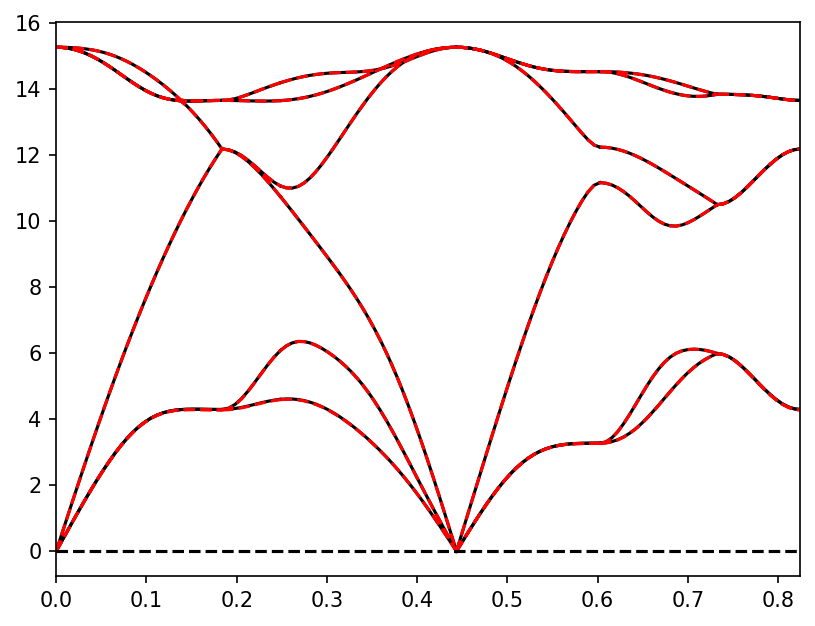

In [11]:
import matplotlib.pyplot as plt
import numpy as np

ref_bands = ref_phonon.get_band_structure_dict()["frequencies"]
nd_bands = ndsc_calc.phonons.get_band_structure_dict()["frequencies"]
qpoints = ndsc_calc.phonons.get_band_structure_dict()["distances"]


fig, ax = plt.subplots(dpi=150)
for b, q in zip(ref_bands, qpoints):
    ax.plot(q, b, "k")
for b, q in zip(nd_bands, qpoints):
    ax.plot(q, b, "r", linestyle="--")

ax.axhline(0, color="k", linestyle="--")
ax.set_xlim(np.min(qpoints[0]), np.max(qpoints[-1]))